# CityGML Parsing & Mapillary Integration

## Task 1 - Extract Building Footprints

Parse the GML file and extract the geometry of each building (footprint).

Plot all building footprints together on a single plot (e.g., using matplotlib, geopandas, or shapely)

## Assumptions 

CityGML version = 1.0

Level of Detail = 2

## Imports

In [20]:
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mlpPolygon
import matplotlib
import csv
import mapillary.interface as mly
import requests
from PIL import Image
from io import BytesIO
import logging
logging.getLogger("requests").setLevel(logging.ERROR)

## Namespace Declarations

In [21]:
tree = ET.parse(".\\690_5334.gml")
root = tree.getroot()
namespace = {
    "gml": "http://www.opengis.net/gml",
    "bldg": "http://www.opengis.net/citygml/building/1.0",
    "gen": "http://www.opengis.net/citygml/generics/1.0",
    "citygml": "http://www.opengis.net/citygml/1.0"
}

## Function to get building footprints

In [22]:
#Parsing the tree structure of the file to obtain the groundsurface coordinates
def get_building_footprints(buildings) -> list:
    building_ids = []
    footprints = []
    for building in buildings:
        building_ids.append(building.get("{http://www.opengis.net/gml}id"))
        ground_surface = building.findall(".//bldg:GroundSurface",namespaces=namespace)
        for surface in ground_surface:
            polygons = surface.findall(".//gml:Polygon",namespaces=namespace)
            for polygon in polygons:
                # Extracting the Coordinates and spliting based on whitespaces between them.
                poslist = polygon.find(".//gml:posList",namespaces=namespace).text.strip().split()
                xy_coords = [(float(poslist[i]),float(poslist[i+1])) for i in range(0,len(poslist),3)]
                z_coords = [float(poslist[i+2]) for i in range(0,len(poslist),3)]
                '''if len(set(z_coords)) ==1:
                   # All elevation levels are same inidcating a ground surface'''
                footprints.append(xy_coords)
    return building_ids, footprints

## Function to plot building footprints using matplotlib

In [23]:
def mlpplot_building_footprints(building_ids,footprints):
  fig, ax = plt.subplots(figsize =(15,12))
  for coords in footprints:
    patch = mlpPolygon(coords, facecolor='lightblue', edgecolor='navy', alpha=0.7)
    ax.add_patch(patch)

  all_x = [x for coords in footprints for x,y in coords]
  all_y = [y for coords in footprints for x,y in coords]
  ax.set_xlim(min(all_x), max(all_x))
  ax.set_ylim(min(all_y), max(all_y))
  ax.set_aspect('equal')
  ax.set_title(f"Building Footprints ({len(footprints)} buildings)")
  ax.set_axis_off()
  plt.savefig("static_plot.png",bbox_inches='tight')

## Function to plot building footprints using GeoPandas

In [28]:
def plot_building_footprints(building_ids, footprints):
    building_geometries = [Polygon(coords) for coords in footprints]
    area = [bld.area for bld in building_geometries]
    geo_dataframe = gpd.GeoDataFrame( {'building_ids':building_ids,'area':area},
                                geometry=building_geometries,
                                 crs  = 25832)
    map = geo_dataframe.explore(color='lightblue', style_kwds={'color': 'navy'}, popup= True)
    map.save('map.html')

## Parsing GML data and making plot calls

Total Buildings Parsed 5479
5479 Building Footprints Extracted
GeoPandas plot is saved as map.html
Matplotlib plot is saved as static_plot.png


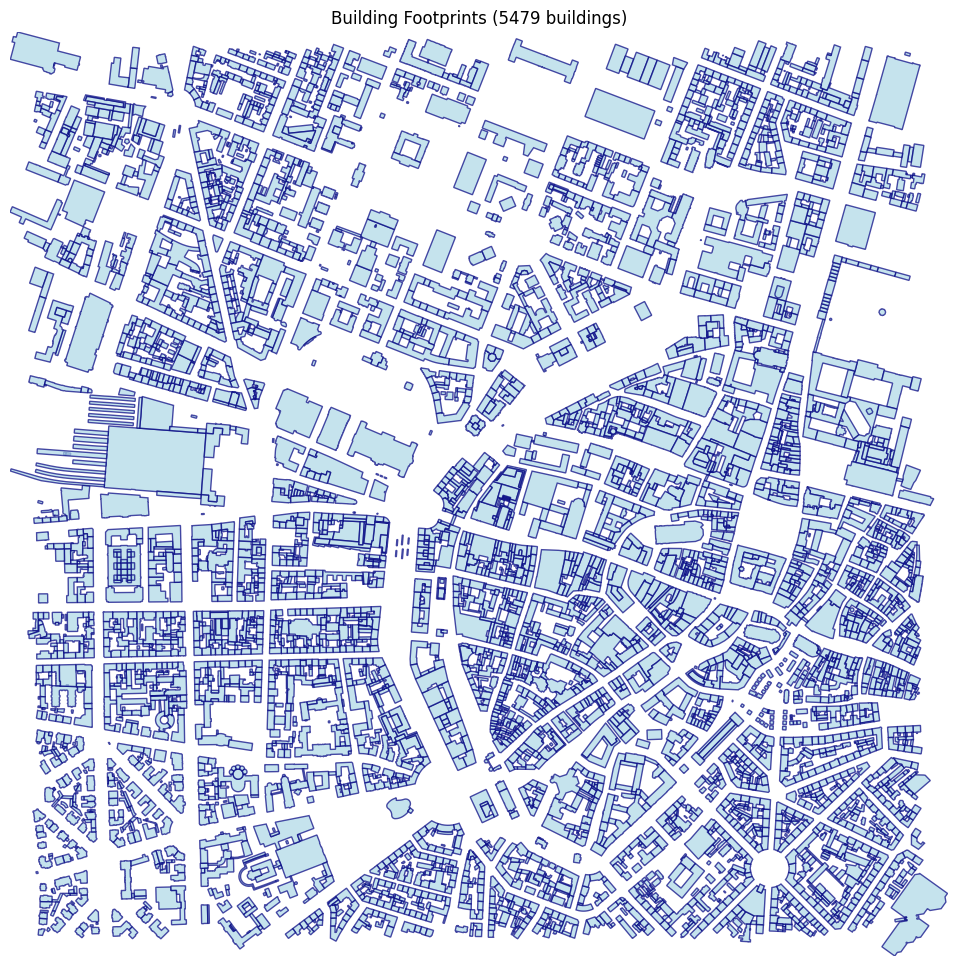

In [29]:
buildings = root.findall(".//bldg:Building",namespaces=namespace)
if buildings:
    print(f'Total Buildings Parsed {len(buildings)}')

    building_ids, footprints = get_building_footprints(buildings)
    print(f"{len(footprints)} Building Footprints Extracted")
    
    plot_building_footprints(building_ids,footprints)
    print('GeoPandas plot is saved as map.html')
    mlpplot_building_footprints(building_ids,footprints)
    print('Matplotlib plot is saved as static_plot.png')
else:
    print("No Buildings Found!")


## Task 2. Extract Building Attributes
Parse and list available attributes for each building (e.g., name, number of
storeys, building function, etc.).

Present the extracted data in a readable format (CSV or printed summary).

In [37]:
buildings_attributes = []
for building in buildings:
  building_data = {}
  if building is not None:
    building_data['ID'] = building.get('{http://www.opengis.net/gml}id')
    name = building.find(".//citygml:externalReference/citygml:externalObject/citygml:name",namespaces=namespace)
    building_data['Name'] = name.text if name is not None else None
    location = building.find('.//gen:stringAttribute[@name="DatenquelleLage"]/gen:value',namespaces=namespace)
    building_data['Location'] = location.text if location is not None else None
    community = building.find('.//gen:stringAttribute[@name = "Gemeindeschluessel"]/gen:value',namespaces=namespace)
    building_data['Community'] = community.text if community is not None else None
    function = building.find('bldg:function',namespaces=namespace)
    building_data['Function'] = function.text if function is not None else None
    roof_type = building.find('bldg:roofType',namespaces=namespace)
    building_data['Roof Type'] = roof_type.text if roof_type is not None else None
    storeys = building.find('bldg:storeysAboveGround',namespaces=namespace)
    building_data['Storeys'] = int(storeys.text) if storeys is not None else None
    height = building.find('bldg:measuredHeight',namespaces=namespace)
    building_data['Building Height'] = float(height.text) if height is not None else None
    area = building.find('.//bldg:GroundSurface/gen:stringAttribute[@name="Flaeche"]/gen:value', namespace)
    building_data['Ground Surface Area'] =  area.text if area is not None else None
    buildings_attributes.append(building_data)

headers = list(buildings_attributes[0].keys())
with open('building.csv','w',newline='') as file:
      writer = csv.DictWriter(file,fieldnames=headers)
      writer.writeheader()
      writer.writerows(buildings_attributes)
print('Building Attributes Successfully written to building.csv')

Building Attributes Successfully written to building.csv


## Bonus Task 3. Retrieve Building Images from Mapillary

For each building, use the Mapillary Python SDK to search and download
street-level images around it within a 50m radius. Print the image IDs.

Provide sample code showing how to access Mapillary images via API.

Tip: you may need to register a developer account to get a valid access token.


In [ ]:
my_token = 'MLY|24215326238121314|600b117c12634ee0abb9bbb5ba7a6d6a'
mly.set_access_token(my_token)

building_geometries = [Polygon(coords) for coords in footprints]
centroid = [bld.centroid for bld in building_geometries]
geo_dataframe = gpd.GeoDataFrame( {'building_ids':building_ids,'geometry':centroid},
                                 crs  = 25832)

#Coordinate Reference System Transformation from EPSG:25832 to EPSG:4326
geo_dataframe_std = geo_dataframe.to_crs(4326) 

for i in range (len(geo_dataframe_std)):
    image_ids = []
    data = mly.get_image_close_to(longitude= geo_dataframe_std['geometry'][i].x, latitude= geo_dataframe_std['geometry'][i].y,radius = 50,)
    for feature in data.features:
        image_ids.append(feature.properties.id)
    print(f"The image ids of buildings nearby the {geo_dataframe_std['building_ids'][i]} are {image_ids}")

Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/8718/5685/?access_token=MLY%7C24215326238121314%7C600b117c12634ee0abb9bbb5ba7a6d6a
Response 200 OK received in 327ms
The image ids of buildings nearby the DEBY_LOD2_59772 are [593701102745742, 1630515634003928, 1442474112755790, 765596740805463, 301128811610220, 4194985817249518, 362690791841140, 2524157641285030, 2657825151042490, 1149405265573541, 1030072645042061, 735719916080470, 645223327899773, 926497315247706, 898265451017269, 1827418911141432, 1067092515564881, 307080717678358, 594634824836548, 997699394713285, 1015007615570090, 955419281672675, 172565998981785, 2743604679163292, 1365359324188827, 553658752705139, 256675220313253, 1915095755935288, 289220140339248, 284258539840596, 3680889362215044, 1199462703846175, 486960195880786, 1789484531989201, 311378047109850, 1478627922930422, 136427411851743, 160194290398162, 494743211835631, 1056958819901039, 3858108277666800, 482664076186300, 1142026487823873, 1

## Retrieve Building Images via Mapillary API

In [33]:
def get_image_by_id(image_id):
    headers = { 'Authorization': f'OAuth {'MLY|24215326238121314|600b117c12634ee0abb9bbb5ba7a6d6a'}',
            'Content-Type': 'application/json'}
    response = requests.get(f"https://graph.mapillary.com/{image_id}?fields=thumb_2048_url",headers= headers)
    image_url = response.json().get('thumb_2048_url')
    if image_url:
        image_response = requests.get(image_url)
        image = Image.open(BytesIO(image_response.content))
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Mapillary Image ID: {image_id}')
        plt.show()
    else:
        print(f"No image URL found for ID: {image_id}")

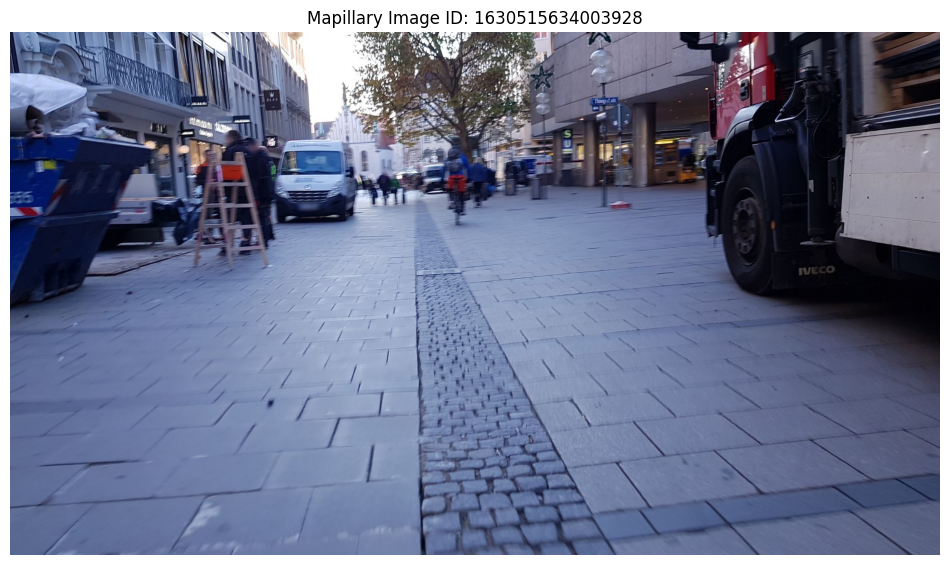

In [36]:
get_image_by_id(1630515634003928)